## Import nesessary libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

## Read the Data from CSV file and assign it to a Dataframe

In [2]:
Df_AirLines= pd.read_csv("EastWestAirlines.csv")

In [3]:
Df_AirLines.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [4]:
Df_AirLines.shape

(3999, 12)

In [5]:
# Since ID coulumn doesnt have info remove column id

Df_AirLines = Df_AirLines.drop(columns=['ID'])
Df_AirLines.head()


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
0,28143,0,1,1,1,174,1,0,0,7000,0
1,19244,0,1,1,1,215,2,0,0,6968,0
2,41354,0,1,1,1,4123,4,0,0,7034,0
3,14776,0,1,1,1,500,1,0,0,6952,0
4,97752,0,4,1,1,43300,26,2077,4,6935,1


## The goal is to try to identify clusters of passengers that have similar characteristics for the purpose of targeting different segments for different types of mileage offers

## Data investigation

###Check for Null values, Duplicates rows, datatypes,outliers, corelation and skewness

In [6]:
## finding null values
Df_AirLines.isnull().sum()

Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award                0
dtype: int64

In [7]:
## check for duplicate rows
Df_AirLines.duplicated().sum()

1

In [8]:
## check the datatypes
Df_AirLines.dtypes

Balance              int64
Qual_miles           int64
cc1_miles            int64
cc2_miles            int64
cc3_miles            int64
Bonus_miles          int64
Bonus_trans          int64
Flight_miles_12mo    int64
Flight_trans_12      int64
Days_since_enroll    int64
Award                int64
dtype: object

<Axes: >

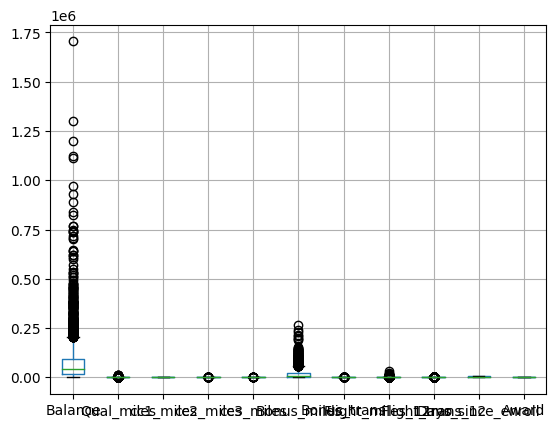

In [9]:
## Check for outliers
Df_AirLines.boxplot()

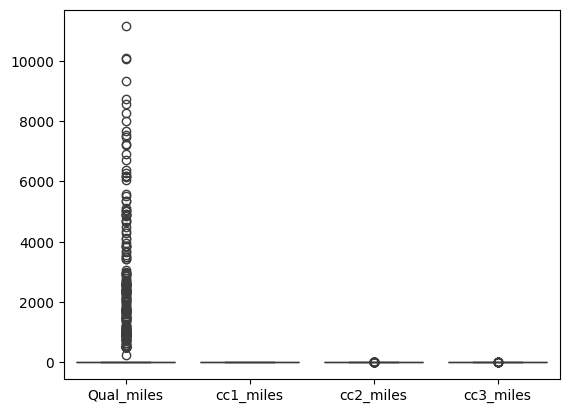

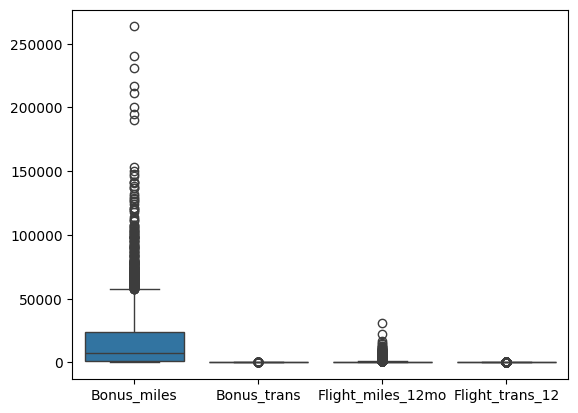

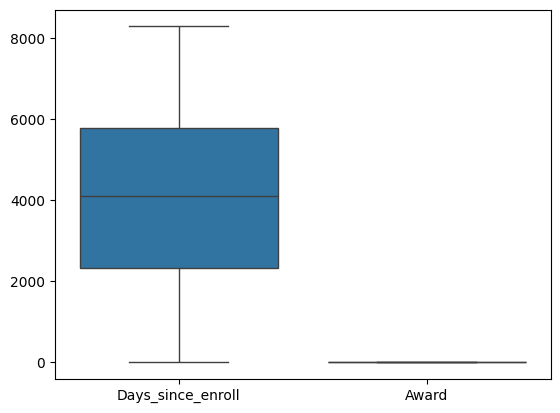

In [10]:
# prompt: show the boxplot for only 4 columns at a time and the remining in another 4 in another boxplot

import seaborn as sns

# Select the first 4 columns
cols_1 = Df_AirLines.iloc[:, 1:5]

# Create a boxplot for the first 4 columns
sns.boxplot(data=cols_1)
plt.show()

# Select the remaining 4 columns
cols_2 = Df_AirLines.iloc[:, 5:9]

# Create a boxplot for the remaining 4 columns
sns.boxplot(data=cols_2)
plt.show()

# Select the remaining 4 columns
cols_3 = Df_AirLines.iloc[:, 9:]
# Create a boxplot for the remaining 4 columns
sns.boxplot(data=cols_3)
plt.show()


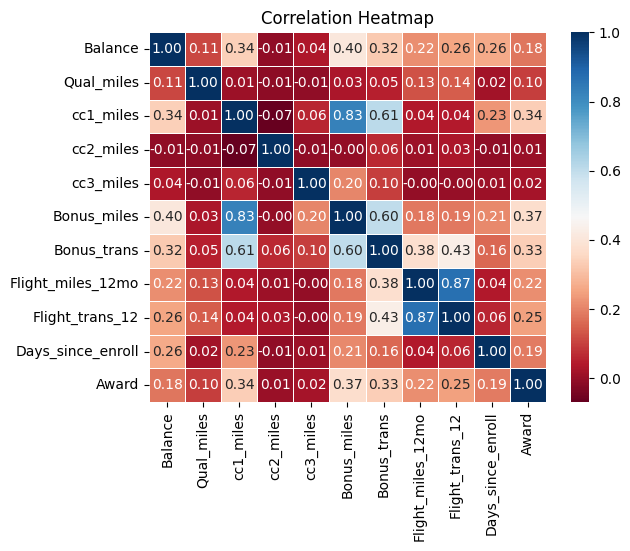

In [11]:
# prompt: Corellation heatmap among the coulmns

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = Df_AirLines.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True,cmap='RdBu', fmt=".2f", linewidths=0.5)

# Set the plot title
plt.title("Correlation Heatmap")

# Display the plot
plt.show()


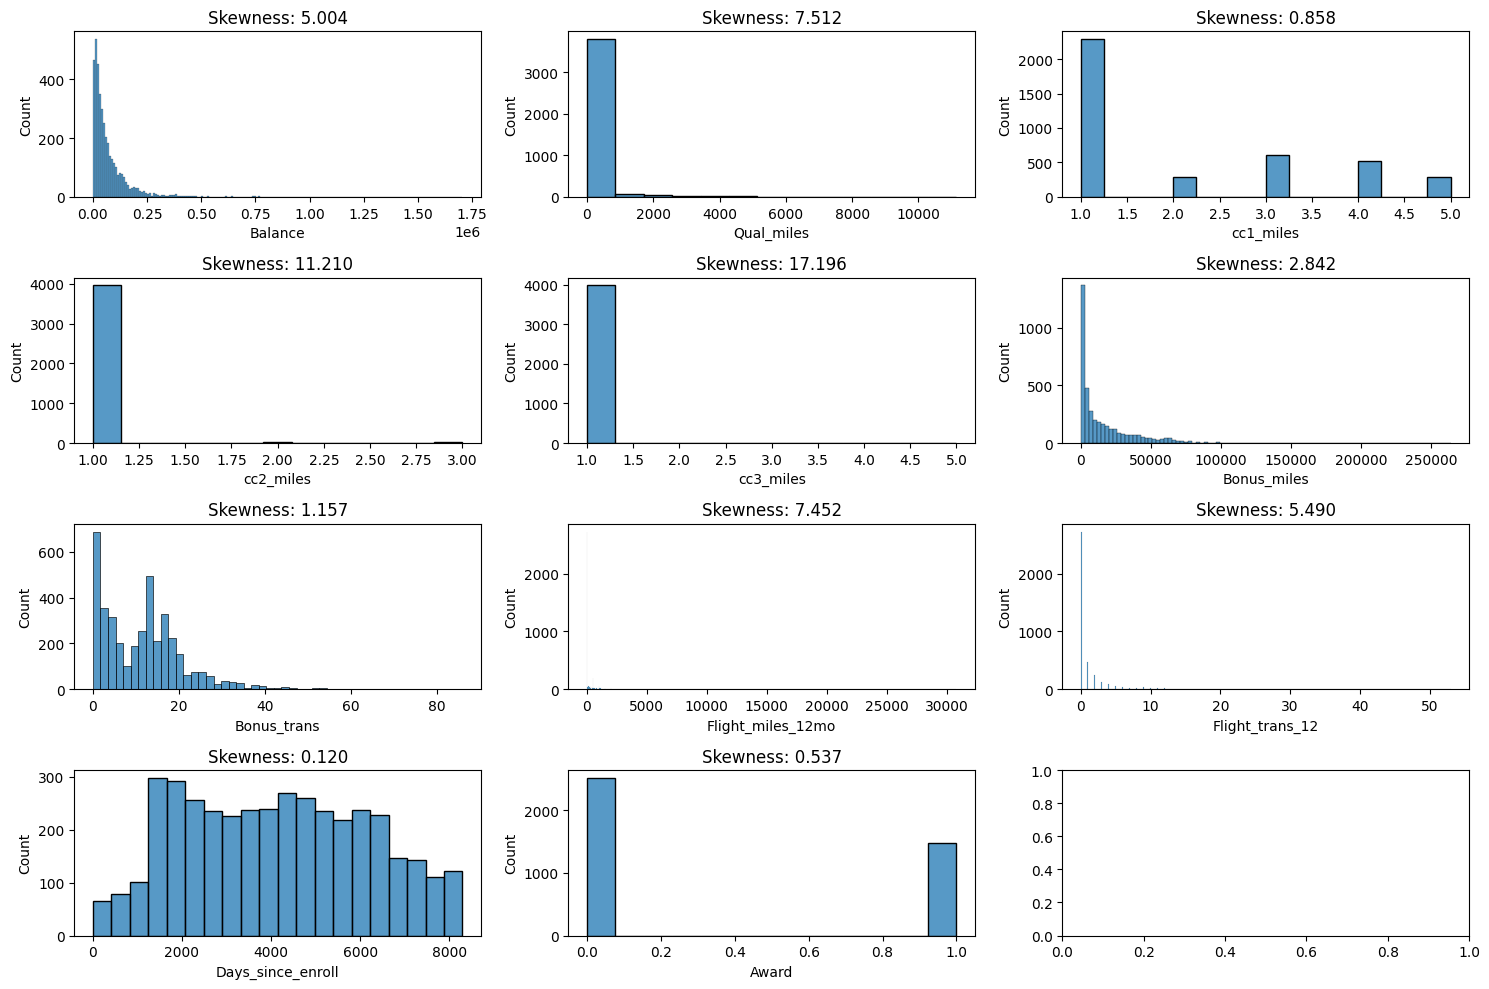

In [12]:
# Select the desired columns
cols = Df_AirLines.iloc[:, 0:]

# Create the subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 10))

# Plot the histograms with skewness values
for i, col in enumerate(cols):
    sns.histplot(Df_AirLines[col], ax=axes[i //3 , i % 3], kde=False)
    skewness = Df_AirLines[col].skew()
    axes[i // 3, i % 3].set_title(f"Skewness: {skewness:.3f}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### All the issues that I had found in the previous part
  1-Big correlation between some columns

  2- Different scales and outliers

  3- Skwewness in our data (right)





## Data Preprocessing

### Treating correlation
  2 coulumns 'Bonus_miles' and 'Flight_trans_12' can be dropped

In [13]:
Df_AirLines_preprocessed = Df_AirLines.drop(columns=['Bonus_miles','Flight_trans_12'])

In [14]:
Df_AirLines_preprocessed.head()


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_trans,Flight_miles_12mo,Days_since_enroll,Award
0,28143,0,1,1,1,1,0,7000,0
1,19244,0,1,1,1,2,0,6968,0
2,41354,0,1,1,1,4,0,7034,0
3,14776,0,1,1,1,1,0,6952,0
4,97752,0,4,1,1,26,2077,6935,1


### Treating outliers

Treat outlier using Inter Quantile Range(IQR) or Winsorization
use trimm and capping

In [15]:
# Function to calculate the percentage of outliers using the IQR method
def calculate_outlier_percentage(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    percentage = (len(outliers) / len(column)) * 100
    return percentage

# Calculate the percentage of outliers for each column
outlier_percentages = Df_AirLines_preprocessed.apply(calculate_outlier_percentage)

# Print the percentage of outliers for each column
print("Percentage of outliers in each column:")
print(outlier_percentages)

Percentage of outliers in each column:
Balance               6.651663
Qual_miles            5.651413
cc1_miles             0.000000
cc2_miles             1.075269
cc3_miles             0.450113
Bonus_trans           1.575394
Flight_miles_12mo    14.228557
Days_since_enroll     0.000000
Award                 0.000000
dtype: float64


In [16]:
# Function to apply outlier treatment by capping
def cap_outliers(data, cap_value):
    capped_data = data.copy()  # Create a copy to avoid modifying the original
    for column in capped_data.columns:  # Iterate through each column
        Q1 = capped_data[column].quantile(0.25)
        Q3 = capped_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        capped_data[column] = np.where(capped_data[column] > upper_bound, upper_bound, capped_data[column])
        capped_data[column] = np.where(capped_data[column] < lower_bound, lower_bound, capped_data[column])
    return capped_data

# Apply outlier treatment
Df_AirLines_preprocessed_wo_outliers = cap_outliers(Df_AirLines_preprocessed, 3)


In [17]:
# Calculate the percentage of outliers for each column
outlier_percentages = Df_AirLines_preprocessed_wo_outliers.apply(calculate_outlier_percentage)

# Print the percentage of outliers for each column
print("Percentage of outliers in each column:")
print(outlier_percentages)

Percentage of outliers in each column:
Balance              0.0
Qual_miles           0.0
cc1_miles            0.0
cc2_miles            0.0
cc3_miles            0.0
Bonus_trans          0.0
Flight_miles_12mo    0.0
Days_since_enroll    0.0
Award                0.0
dtype: float64


### Treating Skewness



#### Using log transform

In [18]:
log_transform_df=(np.log(Df_AirLines_preprocessed+0.1))

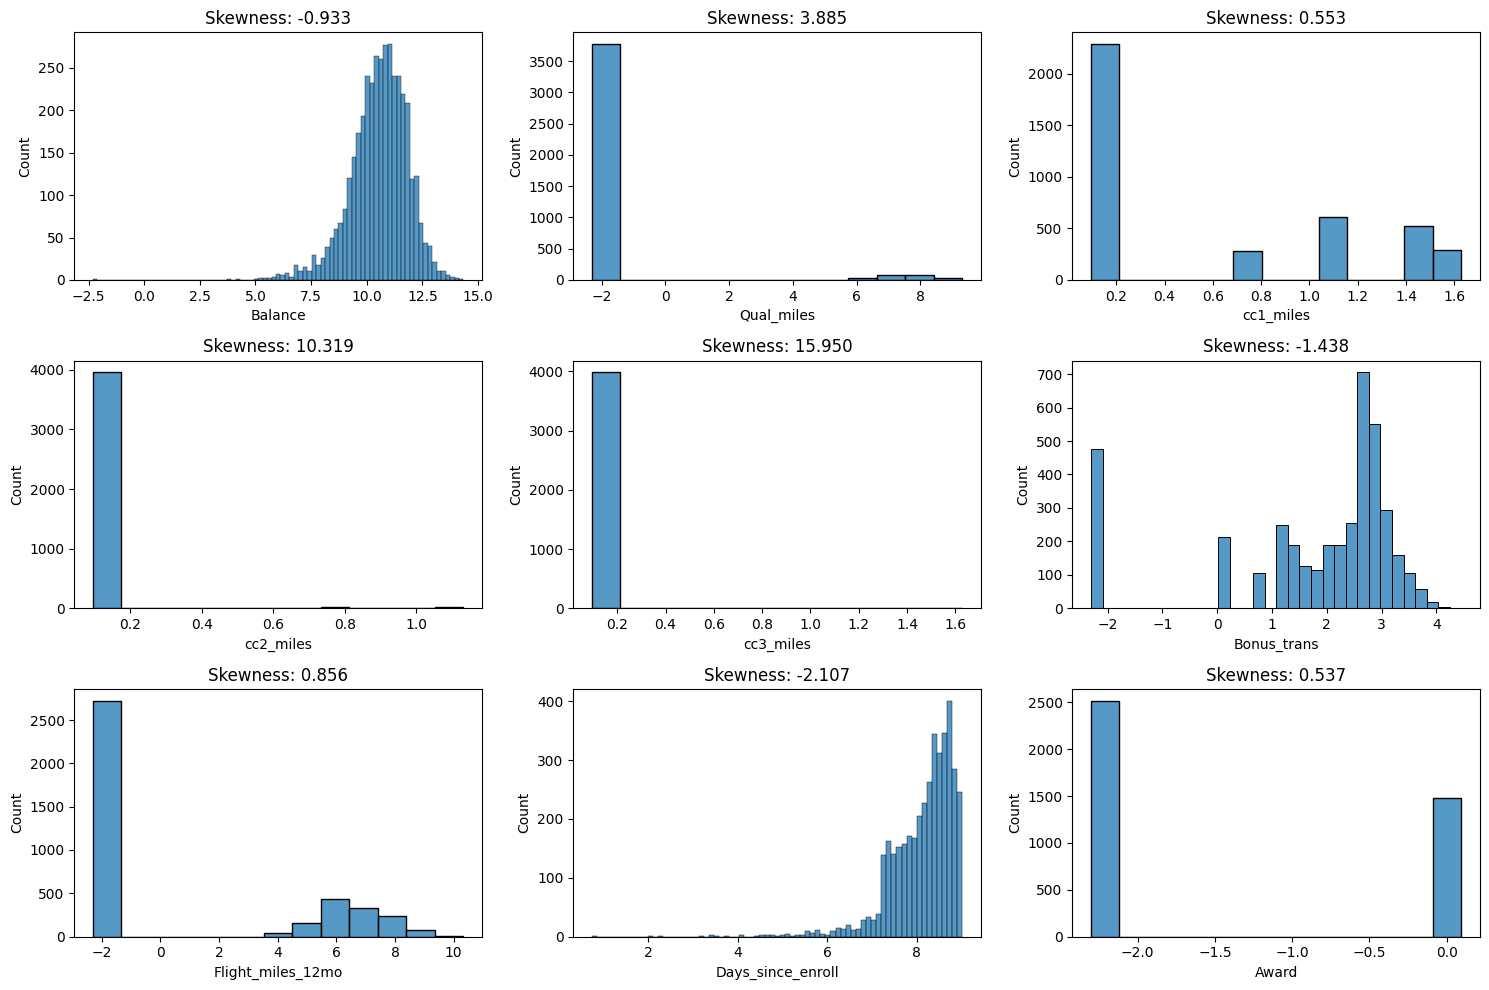

In [19]:
# Select the desired columns
cols = log_transform_df.iloc[:, 0:]

# Create the subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Plot the histograms with skewness values
for i, col in enumerate(cols):
    sns.histplot(log_transform_df[col], ax=axes[i //3 , i % 3], kde=False)
    skewness = log_transform_df[col].skew()
    axes[i // 3, i % 3].set_title(f"Skewness: {skewness:.3f}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### Using Quantile Transformer

In [20]:
from sklearn.preprocessing import QuantileTransformer

quantile_transformer = QuantileTransformer(output_distribution='normal')
standardized_data = quantile_transformer.fit_transform(Df_AirLines_preprocessed)
standardized_data_df = pd.DataFrame(standardized_data, columns=Df_AirLines_preprocessed.columns)

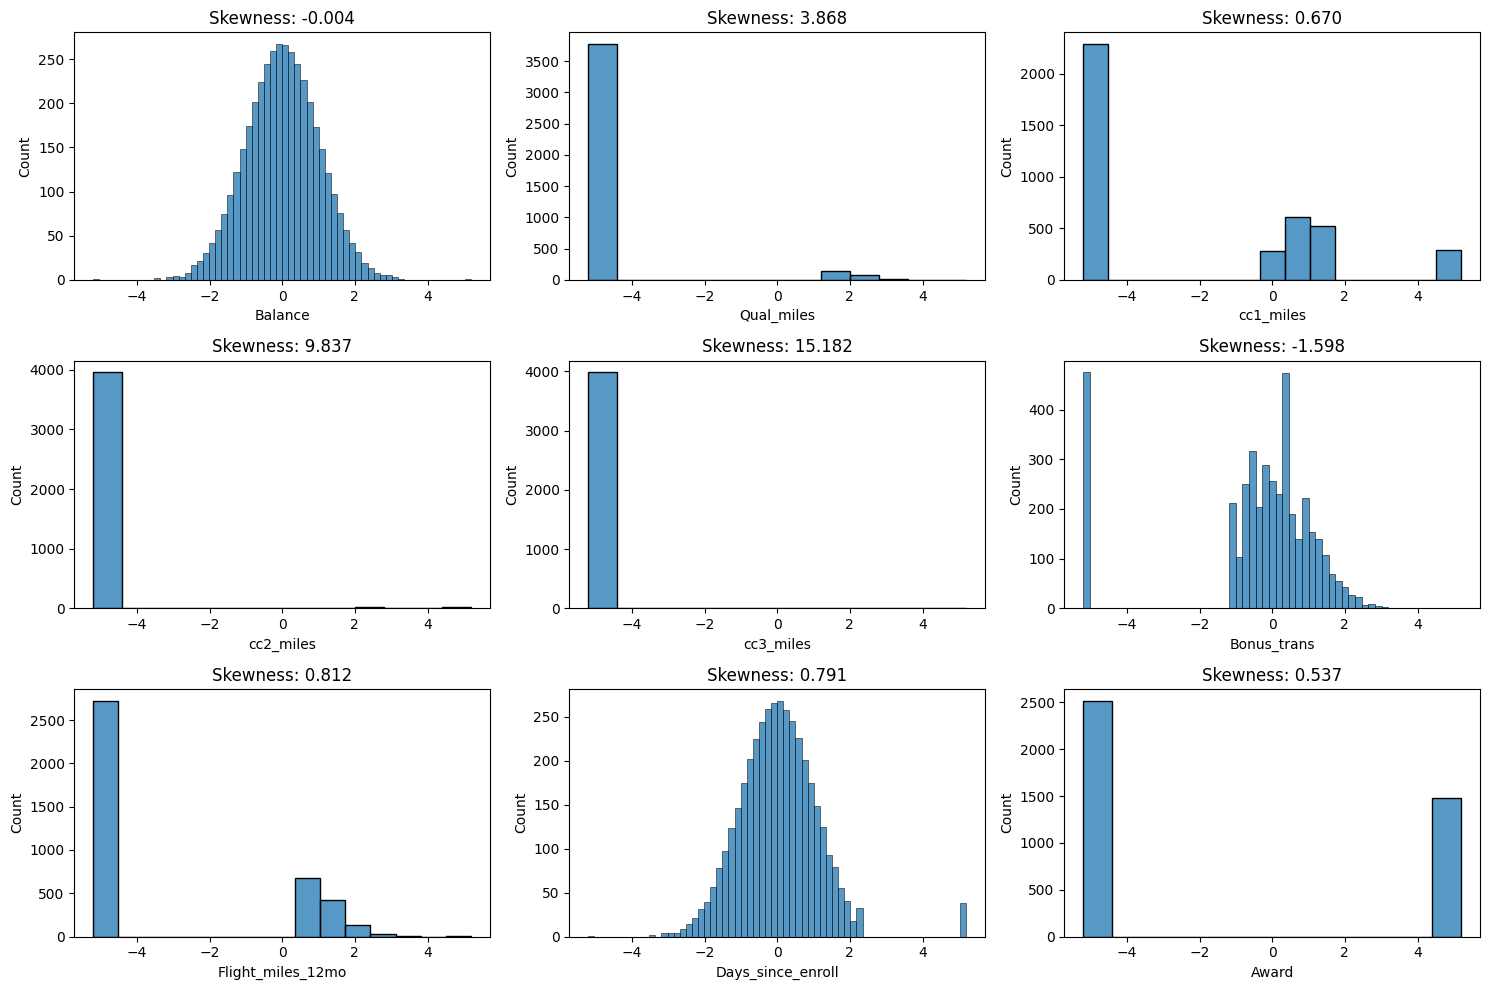

In [21]:
# Select the desired columns
cols = standardized_data_df.iloc[:, 0:]

# Create the subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Plot the histograms with skewness values
for i, col in enumerate(cols):
    sns.histplot(standardized_data_df[col], ax=axes[i //3 , i % 3], kde=False)
    skewness = standardized_data_df[col].skew()
    axes[i // 3, i % 3].set_title(f"Skewness: {skewness:.3f}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Finding suitable number of clusters using Elbow method

In [22]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,random_state=0)
    kmeans.fit(log_transform_df)
    wcss.append(kmeans.inertia_)
    if i > 2:
      break

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

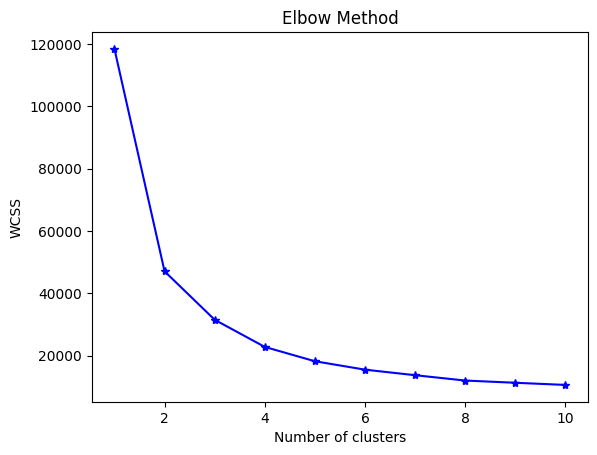

In [23]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,random_state=0)
    kmeans.fit(log_transform_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, 'b*-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Plotting data in 2D using TNSE plot

### TNSE with log transform Data

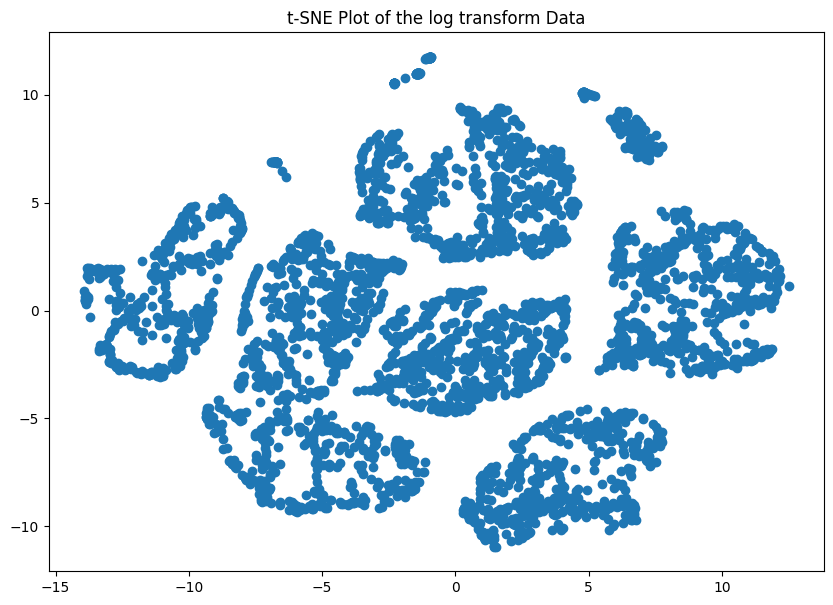

In [24]:
# prompt: T SNE plot for the data

from sklearn.manifold import TSNE

# Initialize and fit the TSNE model
#tsne_model = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3)
tsne_model=TSNE(n_components=2,  perplexity=30, learning_rate=0.1, n_iter=2000)
transformed_data = tsne_model.fit_transform(log_transform_df)

# Create a scatter plot of the transformed data
plt.figure(figsize=(10, 7))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
plt.title('t-SNE Plot of the log transform Data')
plt.show()


### TNSE with standardized_data

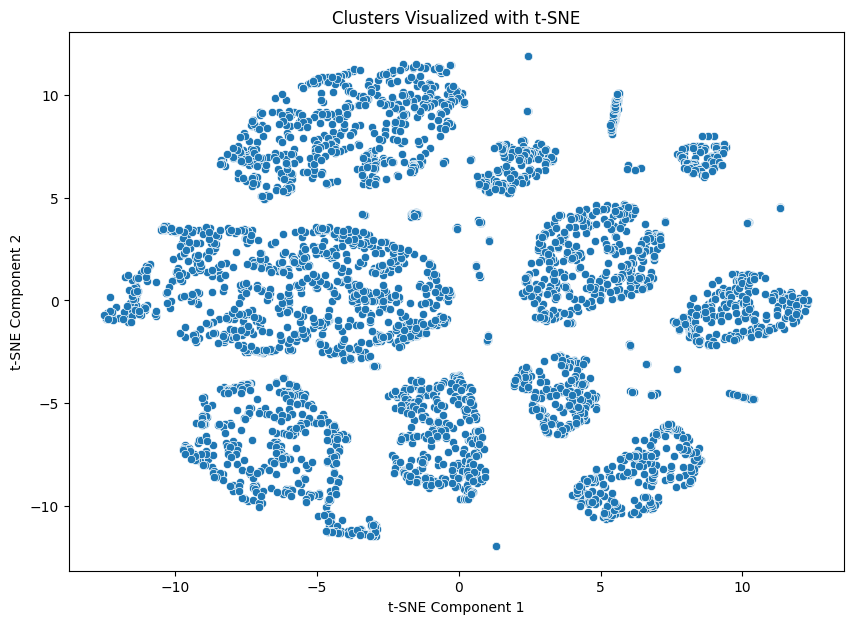

In [25]:
# Apply t-SNE to reduce dimensions to 2 for visualization

tsne = TSNE(n_components=2,  perplexity=30, learning_rate=0.1, n_iter=2000)
X_tsne = tsne.fit_transform(standardized_data_df)

# Add the cluster information to the reduced data
df_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE Component 1', 't-SNE Component 2'])

# Plotting
plt.figure(figsize=(10, 7))
sns.scatterplot(x='t-SNE Component 1', y='t-SNE Component 2', data=df_tsne)
plt.title('Clusters Visualized with t-SNE')
plt.show()

In [26]:
log_transform_df

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_trans,Flight_miles_12mo,Days_since_enroll,Award
0,10.245057,-2.302585,0.095310,0.09531,0.09531,0.095310,-2.302585,8.853680,-2.302585
1,9.864960,-2.302585,0.095310,0.09531,0.09531,0.741937,-2.302585,8.849098,-2.302585
2,10.629927,-2.302585,0.095310,0.09531,0.09531,1.410987,-2.302585,8.858525,-2.302585
3,9.600766,-2.302585,0.095310,0.09531,0.09531,0.095310,-2.302585,8.846799,-2.302585
4,11.490190,-2.302585,1.410987,0.09531,0.09531,3.261935,7.638728,8.844351,0.095310
...,...,...,...,...,...,...,...,...,...
3994,9.824233,-2.302585,0.095310,0.09531,0.09531,1.410987,5.298817,7.246439,0.095310
3995,11.072638,-2.302585,0.095310,0.09531,0.09531,1.629241,-2.302585,7.240721,0.095310
3996,11.206361,-2.302585,1.131402,0.09531,0.09531,2.091864,-2.302585,7.245726,0.095310
3997,10.913252,-2.302585,0.095310,0.09531,0.09531,0.095310,6.214808,7.245013,-2.302585


In [27]:
standardized_data_df

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_trans,Flight_miles_12mo,Days_since_enroll,Award
0,-0.341268,-5.199338,-5.199338,-5.199338,-5.199338,-1.057485,-5.199338,1.287541,-5.199338
1,-0.652282,-5.199338,-5.199338,-5.199338,-5.199338,-0.897655,-5.199338,1.274262,-5.199338
2,-0.023812,-5.199338,-5.199338,-5.199338,-5.199338,-0.570161,-5.199338,1.309021,-5.199338
3,-0.859450,-5.199338,-5.199338,-5.199338,-5.199338,-1.057485,-5.199338,1.270794,-5.199338
4,0.740836,-5.199338,1.093272,-5.199338,-5.199338,1.456896,1.517537,1.265832,5.199338
...,...,...,...,...,...,...,...,...,...
3994,-0.677213,-5.199338,-5.199338,-5.199338,-5.199338,-0.570161,0.595437,-1.413561,5.199338
3995,0.351504,-5.199338,-5.199338,-5.199338,-5.199338,-0.458426,-5.199338,-1.439213,5.199338
3996,0.472274,-5.199338,0.582009,-5.199338,-5.199338,-0.247134,-5.199338,-1.415836,5.199338
3997,0.209563,-5.199338,-5.199338,-5.199338,-5.199338,-1.057485,0.842694,-1.418119,-5.199338


### Appling K means Algorithem

In [28]:
#Build Cluster algorithm
from sklearn.cluster import KMeans
clusters_new = KMeans(4, random_state=42)
clusters_new.fit(standardized_data_df)
centroids = clusters_new.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
clusters_new.labels_

array([3, 3, 3, ..., 2, 3, 3], dtype=int32)

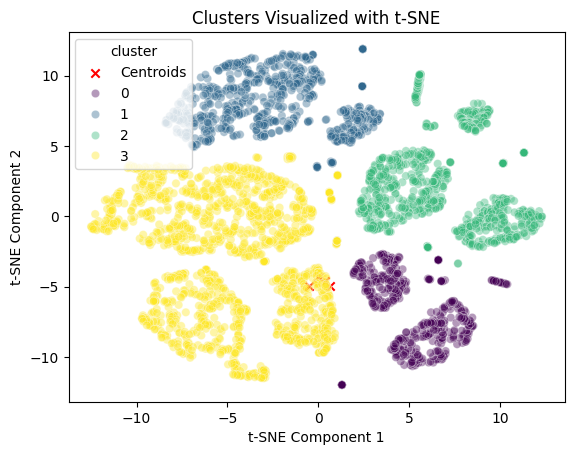

<Figure size 1000x700 with 0 Axes>

In [30]:
# Add the cluster information to the reduced data
df_tsne['cluster'] = clusters_new.labels_

# Plotting
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label='Centroids')
sns.scatterplot(x='t-SNE Component 1', y='t-SNE Component 2', hue='cluster', data=df_tsne, palette='viridis', alpha=0.4 )
plt.title('Clusters Visualized with t-SNE')
plt.figure(figsize=(10, 7))
plt.show()

## Recheking all the above process after treating outliers


### Standerdizing Data without outliers

In [31]:
# prompt: standerdize Df_AirLines_preprocessed_wo_outliers

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_data_wo_outliers = scaler.fit_transform(Df_AirLines_preprocessed_wo_outliers)

standardized_data_wo_outliers = pd.DataFrame(standardized_data_wo_outliers, columns=Df_AirLines_preprocessed_wo_outliers.columns)


### Box Plot for checking outlier info

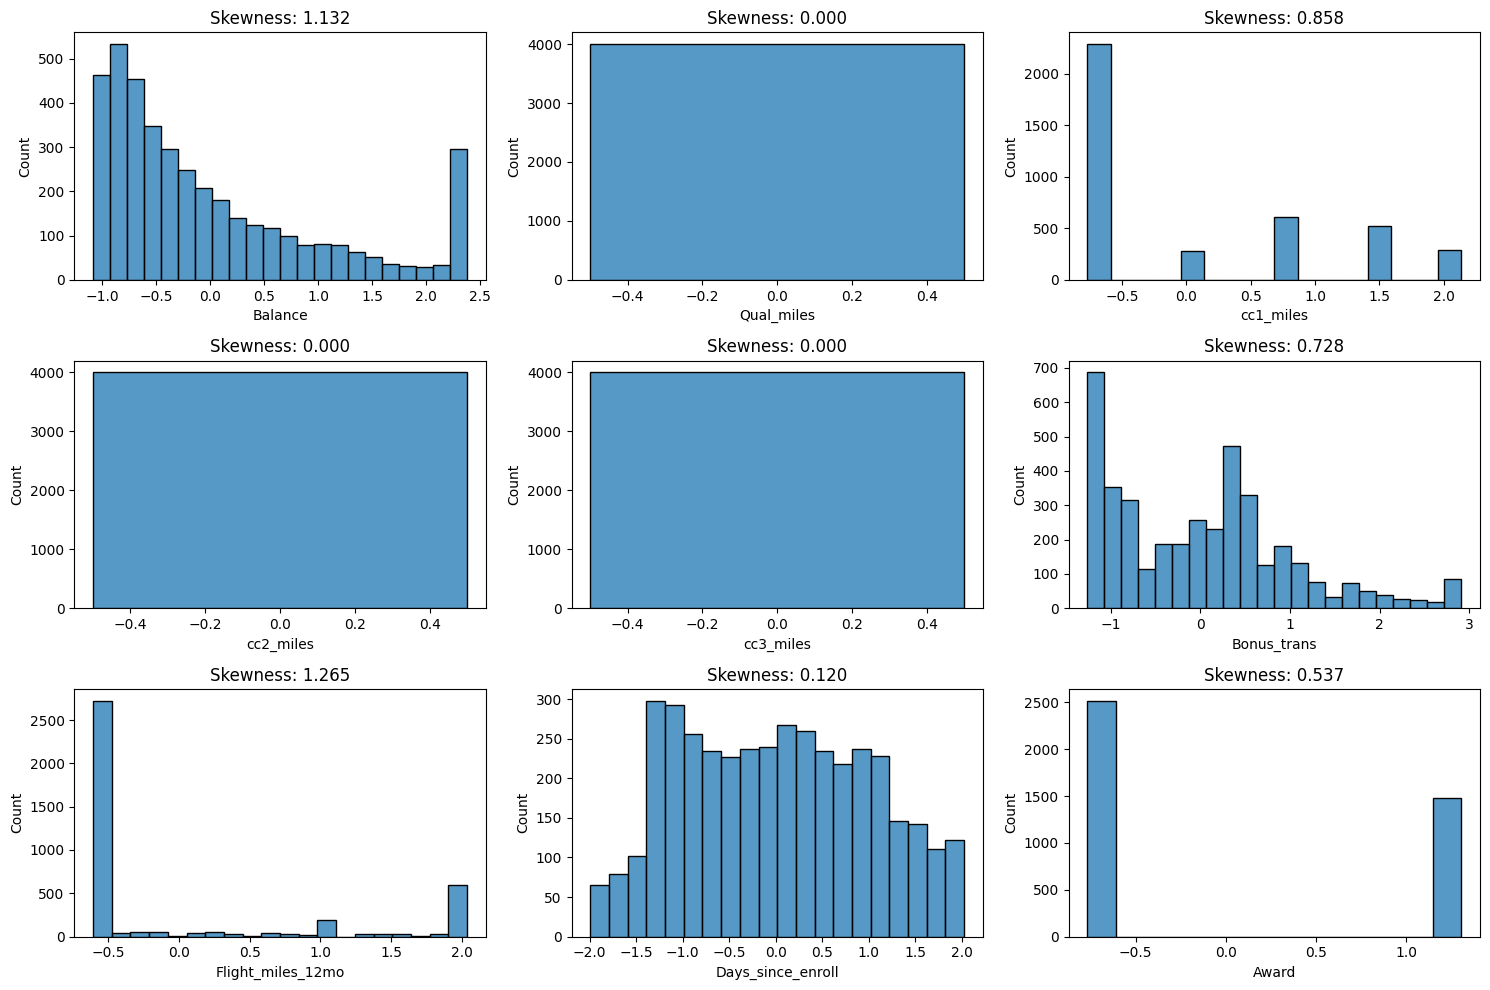

In [32]:

# Select the desired columns
cols = standardized_data_wo_outliers.iloc[:, 0:]

# Create the subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Plot the histograms with skewness values
for i, col in enumerate(cols):
    sns.histplot(standardized_data_wo_outliers[col], ax=axes[i //3 , i % 3], kde=False)
    skewness = standardized_data_wo_outliers[col].skew()
    axes[i // 3, i % 3].set_title(f"Skewness: {skewness:.3f}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### TSNE plot after deleting outliers

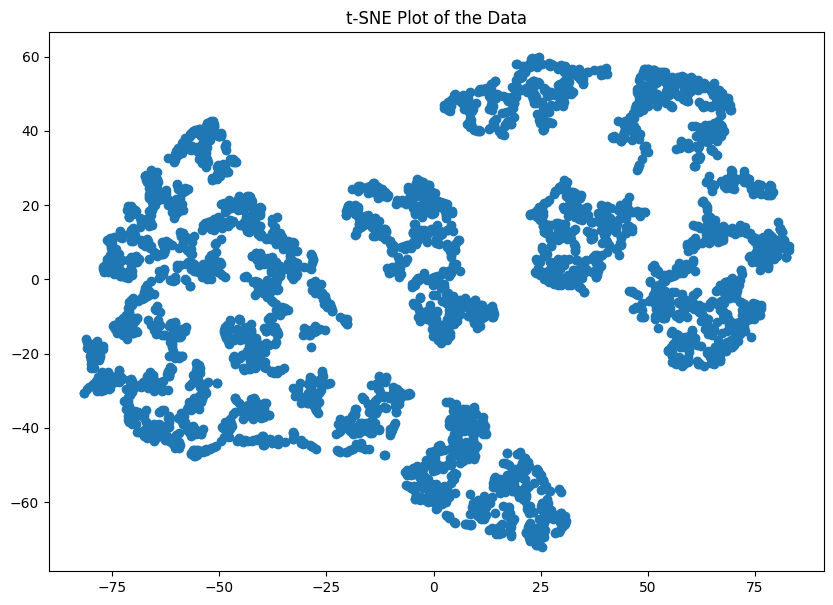

In [33]:

# prompt: T SNE plot for the data

from sklearn.manifold import TSNE

# Initialize and fit the TSNE model
#tsne_model = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3)
tsne_model=TSNE(n_components=2,  perplexity=30, learning_rate='auto', n_iter=2000)
transformed_data_wo_out = tsne_model.fit_transform(standardized_data_wo_outliers)

# Create a scatter plot of the transformed data
plt.figure(figsize=(10, 7))
plt.scatter(transformed_data_wo_out[:, 0], transformed_data_wo_out[:, 1])
plt.title('t-SNE Plot of the Data')
plt.show()

In [34]:
df_transformed_data_wo_out = pd.DataFrame(data=transformed_data_wo_out, columns=['t-SNE Component 1', 't-SNE Component 2'])

### Appling K means algorithem

In [35]:
#Build Cluster algorithm
from sklearn.cluster import KMeans
clusters_new = KMeans(n_clusters=4, init='random',algorithm='lloyd', random_state=100)
clusters_new.fit(standardized_data_wo_outliers)
centroids = clusters_new.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [36]:

clusters_new.labels_

array([0, 0, 0, ..., 2, 0, 0], dtype=int32)

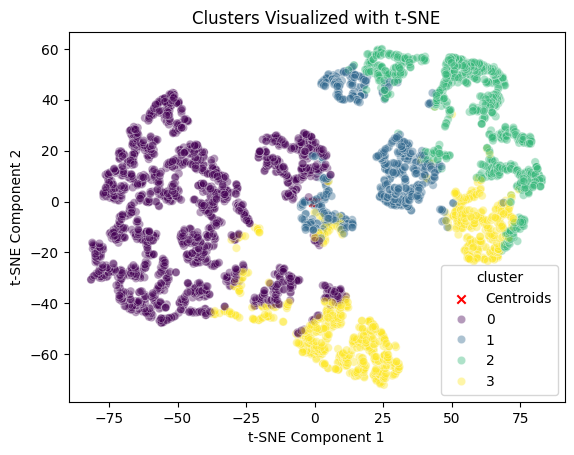

In [37]:
# Add the cluster information to the reduced data
df_transformed_data_wo_out['cluster'] = clusters_new.labels_

# Plotting
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label='Centroids')
sns.scatterplot(x='t-SNE Component 1', y='t-SNE Component 2', hue='cluster', data=df_transformed_data_wo_out, palette='viridis', alpha=0.4 )
plt.title('Clusters Visualized with t-SNE')
plt.show()

In [38]:
standardized_data_wo_outliers.head()


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_trans,Flight_miles_12mo,Days_since_enroll,Award
0,-0.607258,0.0,-0.769578,0.0,0.0,-1.148854,-0.604313,1.395454,-0.766919
1,-0.758947,0.0,-0.769578,0.0,0.0,-1.039133,-0.604313,1.379957,-0.766919
2,-0.382070,0.0,-0.769578,0.0,0.0,-0.819689,-0.604313,1.411920,-0.766919
3,-0.835106,0.0,-0.769578,0.0,0.0,-1.148854,-0.604313,1.372208,-0.766919
4,0.579265,0.0,1.409471,0.0,0.0,1.594189,2.034489,1.363975,1.303918


In [39]:
standardized_data_wo_outliers['cluster'] = clusters_new.labels_

In [40]:
standardized_data_wo_outliers.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_trans,Flight_miles_12mo,Days_since_enroll,Award,cluster
0,-0.607258,0.0,-0.769578,0.0,0.0,-1.148854,-0.604313,1.395454,-0.766919,0
1,-0.758947,0.0,-0.769578,0.0,0.0,-1.039133,-0.604313,1.379957,-0.766919,0
2,-0.382070,0.0,-0.769578,0.0,0.0,-0.819689,-0.604313,1.411920,-0.766919,0
3,-0.835106,0.0,-0.769578,0.0,0.0,-1.148854,-0.604313,1.372208,-0.766919,0
4,0.579265,0.0,1.409471,0.0,0.0,1.594189,2.034489,1.363975,1.303918,1


## Conclusion

### K means is more culsterized with data having outliers after trating outliers most of the columns have skewness of 0 which causes data to more merged